In [1]:
import numpy as np
import dimod
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [2]:
n = 3
N = n*n

R = np.random.random((n,2))
B = np.random.random((n,2))

D = np.empty((n,n))

for i in range(n):
    for j in range(n):
        D[i][j] = ( (R[i][0]-B[j][0])**2 + (R[i][1]-B[j][1])**2 )**(0.5)

print(D)
Q = {}

[[0.14026264 0.5813269  0.32461268]
 [0.3365784  0.64715126 0.56580031]
 [0.61765182 0.87592895 0.36203899]]


In [3]:

lamba = 2
alpha = 2
print('Alpha: ' + str(alpha))
beta = 2

print('Beta: ' + str(beta))

for i in range(N):
    Q[(i,i)] = D[int(i/n)][i%n]- (alpha * lamba)

print('Q diagonal done.')

Alpha: 2
Beta: 2
Q diagonal done.


In [4]:

for i in range(N):
    for j in range(i+1,N):
        if int(i/n)==int(j/n) or i%n==j%n:
            Q[(i,j)] = beta * lamba


In [5]:
sampler_wo_e = DWaveSampler(config_file='/home/manoj/.config/dwave/dwave.conf',profile='prod',)
sampler = EmbeddingComposite(sampler_wo_e)

In [6]:
print(sampler_wo_e.properties['default_annealing_time'], sampler_wo_e.properties['annealing_time_range'])
print(sampler_wo_e.properties['default_readout_thermalization'],
      sampler_wo_e.properties['default_programming_thermalization'],
      sampler_wo_e.properties['programming_thermalization_range'])
print(sampler_wo_e.properties['num_reads_range'])

(20, [1, 2000])
(0, 1000, [0, 10000])
[1, 10000]


In [7]:
num_reads = 1000
annealing_time= 200
programming_thermalization=sampler_wo_e.properties['default_programming_thermalization']

response = sampler.sample_qubo(Q, num_reads=num_reads, annealing_time=annealing_time,
                               programming_thermalization=programming_thermalization)

print "response:", response

response:     0  1  2  3  4  5  6  7  8      energy  num_occ.  chain_b.
0   1  0  0  0  1  0  0  0  1  -10.850547        97       0.0
1   0  1  0  1  0  0  0  0  1  -10.720056        37       0.0
2   0  0  1  1  0  0  0  1  0   -10.46288       672  0.111111
3   0  0  1  1  0  0  0  1  0   -10.46288         1  0.222222
4   0  0  1  1  0  0  0  1  0   -10.46288         9       0.0
5   1  0  0  0  0  1  0  1  0  -10.418008         8       0.0
6   0  0  1  0  1  0  1  0  0  -10.410584        35       0.0
7   0  1  0  0  0  1  1  0  0  -10.235221        94  0.111111
8   0  0  1  1  0  0  0  0  0   -7.338809         1  0.111111
9   0  1  0  0  0  0  1  0  0   -6.801021         1  0.222222
10  1  1  0  0  0  1  0  0  0    -6.71261         1  0.111111
11  0  0  1  1  1  0  0  0  0   -6.691658         1  0.111111
12  0  0  0  1  1  0  0  0  1   -6.654231         1  0.111111
13  0  1  0  0  0  0  1  0  1   -6.438982         2  0.222222
14  0  0  0  0  1  0  1  0  1   -6.373158         3  0.22222

In [8]:
total_real_time = response.info['timing']['total_real_time']

timing = np.asarray(response.info['timing'].items())

In [11]:
config_tmp = None
energy = []
freq = []

for sample in response.samples():
    x = np.asarray(sample.values())
    if config_tmp is None:
        config_tmp = x
    else:
        config_tmp = np.vstack([config_tmp, x])

    
for smp in response.data(fields=['energy', 'num_occurrences']):
    energy = np.append(energy, smp.energy)
    freq = np.append(freq, smp.num_occurrences)

print config_tmp

configs = config_tmp.astype(bool)

idx = np.argsort(-freq)

configs = configs[idx]
energy = energy[idx]
freq = freq[idx]

configs = [np.array(a).reshape(-1, n) for a in configs]

to_del = []

for c in range(len(configs)):
    row_sum = configs[c].sum(axis=0)
    col_sum = configs[c].sum(axis=1)
    if ( not (np.array_equal(row_sum,np.ones(n, dtype = int)))):
        to_del = np.append(to_del, int(c))
    else:
        if ( not (np.array_equal(col_sum,np.ones(n, dtype = int)))):
            to_del = np.append(to_del, int(c))
            
print format(to_del)

configs = np.delete(configs, to_del, axis=0)
energy = np.delete(energy, to_del)
freq = np.delete(freq, to_del)

print(configs)
print(energy)
print(freq)

{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1}
{0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0}
{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0}
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0}
{0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}
{0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0}
{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0}
{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0}
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1}
{0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1}
{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0}
{0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0}
{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 1}
{0: 0, 1: 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [12]:
cost=np.zeros(len(configs))

for c in range(len(configs)):
    for i in range(n):
        for j in range(n):
            if (configs[c])[i][j] == 1:
                cost[c] += D[i][j]

print(cost)

[1.53712003 1.14945289 1.76477904 1.27994429 1.58941576 1.53712003
 1.5819919  1.53712003]


[[ True False False]
 [False  True False]
 [False False  True]]
1.1494528919766318
('Found a valid min cost result at index ', 1)
('The count of min cost in valid results is ', 1)
('The frequency of min cost in valid results is ', 97.0)


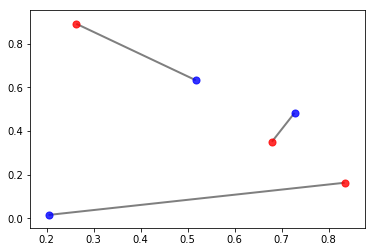

In [14]:
#Brute Force Minimum Check
import itertools as it
import math

f_n = math.factorial(n)

P=np.empty((f_n,n))
    
for i,j in enumerate(it.permutations(range(n))):
    P[i] = j

min_cost = 100

for item in P:
    perm_cost = 0
    for j in range(n):
        perm_cost += D[j][ int(item[j]) ]
    
    if perm_cost < min_cost:
        min_cost = perm_cost
        min_cost_config = item

min_config = np.zeros((n,n), dtype=bool)

for i in range(n):
    min_config[i][ int(min_cost_config[i]) ]=1
    
print(min_config)
print(min_cost)

min_count_cost = 0
min_frequency_count = 0

for c in range(len(configs)):
    if (cost[c] == min_cost): 
        min_count_cost += 1
        min_frequency_count += freq[c]
        print("Found a valid min cost result at index ", c)

print("The count of min cost in valid results is ", min_count_cost)
print("The frequency of min cost in valid results is ", min_frequency_count)

import networkx as nx
import matplotlib.pyplot as plt

G=nx.empty_graph()

nx.draw_networkx_nodes(G,pos=np.concatenate((R,B)),nodelist=range(n),node_color='r',node_size=50,alpha=0.8)
nx.draw_networkx_nodes(G,pos=np.concatenate((R,B)),nodelist=range(n,2*n),node_color='b',node_size=50,alpha=0.8)

E = []

for i in range(n):
    for j in range(n):
        if min_config[i][j]==1:
            E.append((i,n+j))

nx.draw_networkx_edges(G,pos=np.concatenate((R,B)),edgelist=E,width=2,alpha=0.5,edge_color='k')

plt.show()

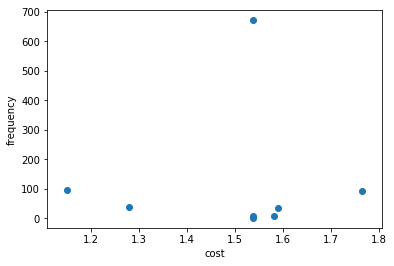

<Figure size 720x720 with 0 Axes>

In [15]:
plt.scatter(cost, freq)
plt.xlabel('cost')
plt.ylabel('frequency')

plt.figure(figsize=(10,10), facecolor='w', edgecolor='w')
plt.show()



Rows and Columns:  3 x 3 





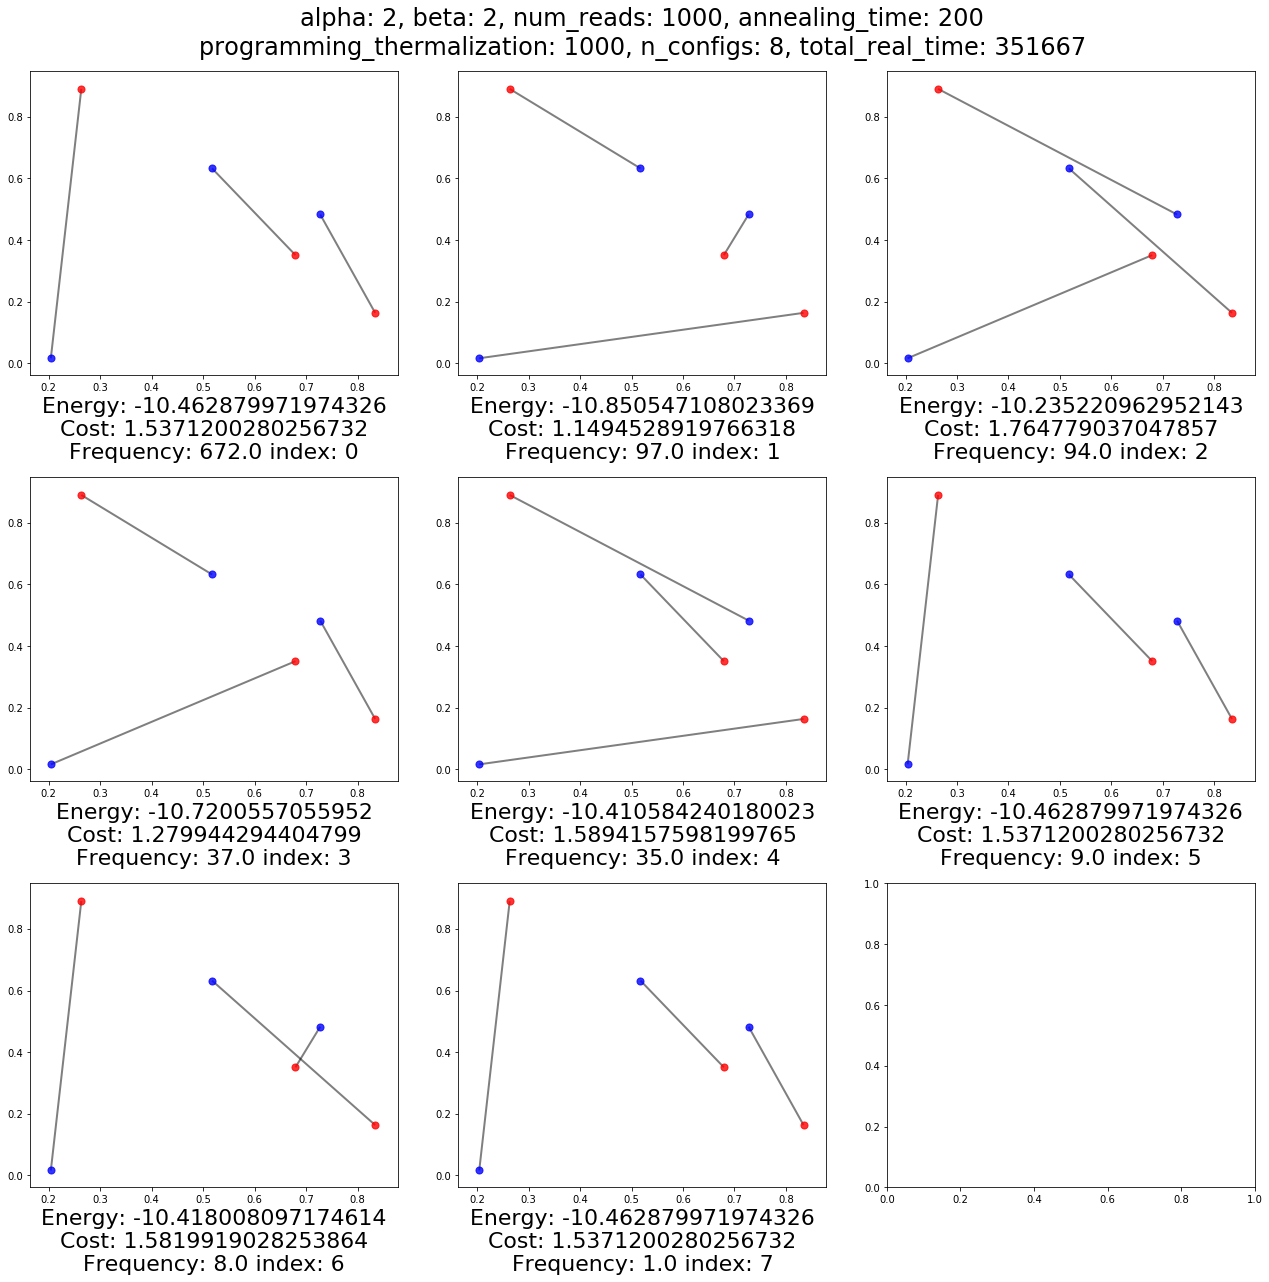

In [16]:
import networkx as nx

n_configs = len(configs)
n_cols = 3
n_rows = int(np.ceil(float(n_configs)/n_cols))

print '\nRows and Columns: ', n_rows, 'x', n_cols, '\n\n\n'
f, axarr = plt.subplots(n_rows, n_cols, figsize=(6*n_cols,6*n_rows), squeeze=False)

f.patch.set_facecolor('white')

for i in range(n_rows):
    for j in range(n_cols):
        k = i*n_cols+j
        if k<n_configs:
            axarr[i][j].set_xlabel('Energy: ' + str(energy[k]) + '\nCost: ' + str(cost[k])
                               + '\nFrequency: ' + str(freq[k]) + ' index: ' + str(k), fontsize=22 )
            
        #axarr[i][j].set_aspect(aspect=1, adjustable='box')

G=nx.empty_graph()

for c in range(n_configs):
       
    nx.draw_networkx_nodes(G,pos=np.concatenate((R,B)),nodelist=range(n),node_color='r',node_size=50,alpha=0.8, ax=axarr[c/n_cols,c%n_cols])
    nx.draw_networkx_nodes(G,pos=np.concatenate((R,B)),nodelist=range(n,2*n),node_color='b',node_size=50,alpha=0.8, ax=axarr[c/n_cols,c%n_cols])

    E = []

    for i in range(n):
        for j in range(n):
            if configs[c][i][j]==1:
                E.append((i,n+j))

    nx.draw_networkx_edges(G,pos=np.concatenate((R,B)),edgelist=E,width=2,alpha=0.5,edge_color='k', ax=axarr[c/n_cols,c%n_cols])
    
f.tight_layout(rect=[0, 0.03, 1, 0.978])
plt.suptitle('alpha: '+str(alpha)+', beta: '+str(beta)+', num_reads: '+str(num_reads)+
             ', annealing_time: '+str(annealing_time)+
             '\nprogramming_thermalization: '+str(programming_thermalization)+
             ', n_configs: '+str(n_configs)+', total_real_time: '+str(total_real_time), verticalalignment='baseline', fontsize=24)
plt.show()

In [29]:
np.savez('outputs/'+str(n)+'_dwave_ocean', R=R, B=B, alpha=alpha, beta=beta, num_reads=num_reads,
         annealing_time=annealing_time, programming_thermalization=programming_thermalization,
        configs=configs, energy=energy, freq=freq, timing=timing)